# Bring in imports

In [2]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


import json  
import pickle
import os
import re
import itertools
import time

import cv2
import argparse as ap


from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD


In [3]:
keras.__version__

'2.1.5'

# Make test and train

In [5]:
image_data = pickle.load(open("image_data.pkl", "rb"))
image_tag = pickle.load(open("image_tag.pkl","rb"))

In [6]:
X = np.asarray(image_data)/255
y = np.asarray(image_tag)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1234, stratify = y, shuffle = True)
print("training on {} chips and testing on {}".format(len(X_train), len(X_test)))


training on 2240 chips and testing on 560


In [8]:
# one-hot encode the labels
y_train = keras.utils.np_utils.to_categorical(y_train, 2)
y_test =  keras.utils.np_utils.to_categorical(y_test, 2)

[0. 1.]


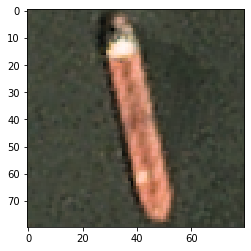

In [20]:
print(y_test[0])
plt.imshow(X_test[0])

# Create & Train Model

In [9]:
# network design
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))


sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)  

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 1234, shuffle = True)


In [46]:
datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
) 

datagen.fit(X_train)

val_datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
) 

val_datagen.fit(X_val)


history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                 shuffle=True, 
                 epochs=3, # training for 3 epochs as example in notebook- up this number for full training
                 verbose=1,
                 validation_data=val_datagen.flow(X_val, y_val, batch_size=32)
                 )


Epoch 1/3
56/56 [==============================] - 13s 234ms/step - loss: 0.2013 - acc: 0.9169 - val_loss: 0.1461 - val_acc: 0.9442
Epoch 2/3
56/56 [==============================] - 12s 218ms/step - loss: 0.1811 - acc: 0.9258 - val_loss: 0.1341 - val_acc: 0.9464
Epoch 3/3
56/56 [==============================] - 13s 225ms/step - loss: 0.1788 - acc: 0.9275 - val_loss: 0.1655 - val_acc: 0.9531


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


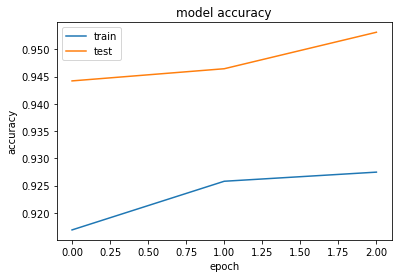

In [48]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

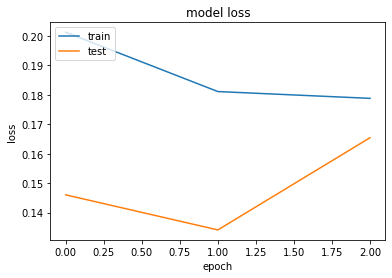

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Make a confusion matrix for fun

In [52]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
y_pred = model.predict(X_test)



Precision:              0.96
Recall:                 0.97
Specificity:              0.88
[[408  12]
 [ 17 123]]


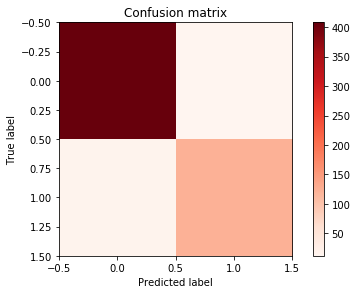

In [71]:
y_test_non_category = [ np.argmax(t) for t in y_train ]

conf = confusion_matrix([ np.argmax(t) for t in y_test ], [ np.argmax(t) for t in y_pred ])
print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))
print(conf)
plot_confusion_matrix(conf)

In [74]:
# Evaluate 
model.evaluate(X_test, y_test, verbose=1)

560/560 [==============================] - 1s 2ms/step


[0.1501523562840053, 0.9482142857142857]

In [75]:
#Save
model.save('final_model.h5')

# Execute Model w/ sliding window

In [76]:
model.load_weights('final_model.h5')

In [79]:
scenes = []
for image in os.listdir('scenes'):
    if image.endswith(".png"):
        scenes.append(os.path.join("scenes/", image))

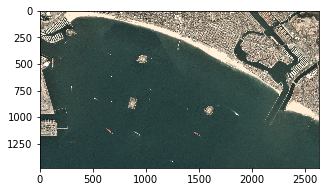

In [80]:
for image in scenes[:1]:
    plt.figure(figsize=(5,10))
    plt.imshow(mpimg.imread(image))

In [112]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def scan_image(model, image, step_size=12, window_size=80, proba=.4):
    output = []
    for (x, y, window) in sliding_window(image, step_size=step_size, window_size=(window_size, window_size)):
        if window.shape[0] != window_size or window.shape[1] != window_size:
            continue
        cnn_window = np.expand_dims(window, axis=0)
        y_pred = model.predict(cnn_window)
        y_pred_val = list(y_pred[0])[1]
        
        if y_pred_val > proba :
            output.append((x,y))
            print("Found ship at {}".format((x,y)))
    return output

def plt_found(cnn_coords,image):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for i in cnn_coords:
        rect = patches.Rectangle(i,80,80,linewidth=4,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

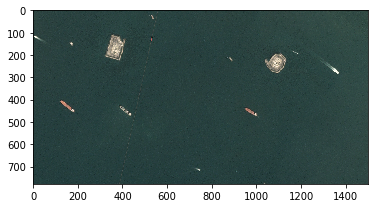

In [113]:
test = mpimg.imread(scenes[0])[700:1700,500:2000, :]
plt.imshow(test)

In [114]:
test = mpimg.imread(scenes[0])[700:1700,500:2000, :]
output = scan_image(model,test)

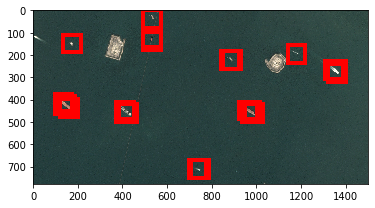

In [116]:
plt_found(output,test)